# 贝叶斯优化

贝叶斯优化是一类可以用于优化黑盒函数的优化方法。对于黑盒函数来说，我们无法得知其显式的表达式，只能通过输入一个数据，观测其输出的方法寻找它的最大值。借助于贝叶斯统计的思想，贝叶斯优化最初认为函数是一个完全随机的函数，可以通过不断地观测来更新对函数的估计（后验）。在每一步迭代中，算法会根据当前的后验，通过采集函数来选择下一个观测的点。贝叶斯优化的优点是可以在较少的迭代次数内找到全局最优解，因此在实际应用中被广泛使用。

假设目标函数的形式如下：

In [1]:
import numpy as np
from scipy.stats import norm

def objective(x):
    return norm.pdf(x, 3, 2) * 1.5 + norm.pdf(x, 7, 1) + norm.pdf(x, 11, 2)

初步对该函数进行可视化

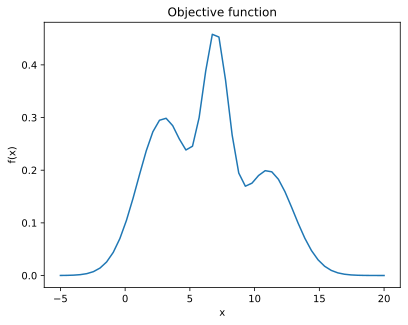

In [2]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'svg'

x = np.linspace(-5, 20, 50)
plt.plot(x, objective(x))
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Objective function')
plt.show()

采集函数的目标是选出后验中最优的点。在此处，我们使用期望改进（Expected Improvement, EI）来选择下一个采集点。EI的定义如下：

$$
\begin{aligned}
\text{EI}(x) &= \mathbb{E}[\max(0, \tilde f(x) - f(x^*) - \xi)] \\
\end{aligned}
$$

其中$\tilde f(x)$是目标函数在$x$处的预测值，$f(x^*)$是当前最优的函数值，$\xi$是一个控制探索和开发的参数，当$\xi$较大时，算法更倾向于探索，当$\xi$较小时，算法更倾向于开发。对于高斯分布，对于给定$x$, $\tilde f(x)$的分布是一个高斯分布，其均值为$\mu(x)$，方差为$\sigma^2(x)$，令

$$
z(x) = \frac{\mu(x) - f(x^*) - \xi}{\sigma(x)}
$$

则期望改进为

$$
\text{EI}(x) = \sigma(x)[z(x)\Phi(z(x)) + \phi(z(x))]
$$

In [3]:
from typing import Callable
from sklearn.gaussian_process import GaussianProcessRegressor

GP = GaussianProcessRegressor
Acquisition = Callable[[np.ndarray, GP, float], np.ndarray]

def expected_improvement(x: np.ndarray, gp: GP, y_max: float, xi: float = 0.01):
    x = np.array(x).reshape(-1, 1)
    mu, sigma = gp.predict(x, return_std=True) # type: ignore
    sigma = sigma.reshape(-1, 1)
    mu = mu.reshape(-1, 1)

    with np.errstate(divide='warn'):
        Z = (mu - y_max - xi) / sigma # Normalized Z-score
        ei = sigma * (Z * norm.cdf(Z) + norm.pdf(Z))

    return ei

根据采集函数，我们可以在范围中选择一个点使得EI最大，然后观测该点的函数值，更新后验，重复这个过程直到达到迭代次数。

In [4]:
def next_point(
    x_min: float, x_max: float, n_samples: int,
    acquisition: Acquisition, gp: GP, y_max: float
):
    x = np.random.uniform(x_min, x_max, n_samples).reshape(-1, 1)
    ei = acquisition(x, gp, y_max)
    return x[np.argmax(ei)]

此后，我们可以使用高斯过程来拟合目标函数。`sklearn`中提供了高斯过程的实现。

/var/folders/wg/gb8y92_d43j60wvfw6bs_cz00000gn/T/ipykernel_54343/3771838051.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


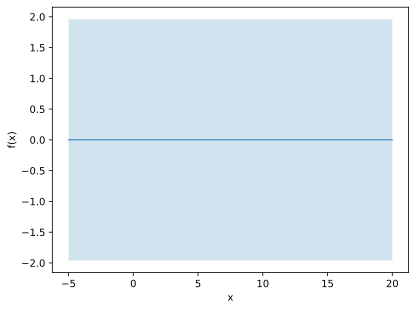

In [5]:
from sklearn.gaussian_process.kernels import RBF

kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gp = GP(kernel=kernel, alpha=1e-5, n_restarts_optimizer=10)

def plot_gp(ax, gp: GP, x_min: float, x_max: float, ci: float = 0.95):
    x = np.linspace(x_min, x_max, 50).reshape(-1, 1)
    y, sigma = gp.predict(x, return_std=True)

    ci_coef = norm.ppf((1 + ci) / 2)

    ax.plot(x, y, linewidth=1)
    ax.fill_between(x.flatten(), y - ci_coef * sigma, y + ci_coef * sigma, alpha=0.2)
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')

fig, ax = plt.subplots(1, 1)
plot_gp(ax, gp, -5, 20)
fig.show()

此后，我们可以迭代地优化目标函数。

/var/folders/wg/gb8y92_d43j60wvfw6bs_cz00000gn/T/ipykernel_54343/3753732084.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


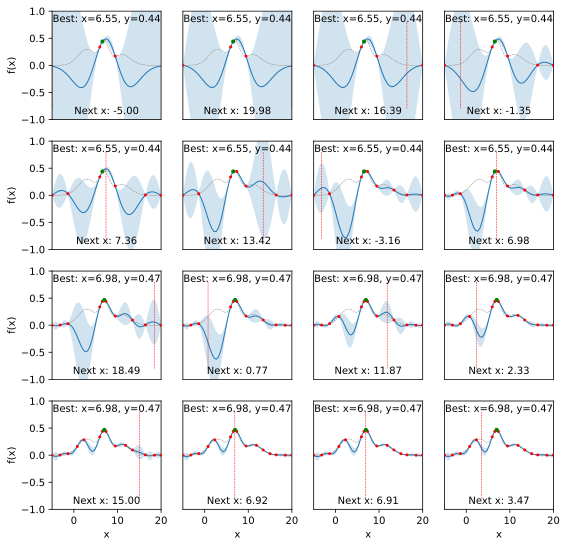

In [6]:
fig, ax = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(9, 9))
ax_flatten = ax.flatten()

x_min = -5
x_max = 20
x_samples = np.random.uniform(x_min, x_max, 3).reshape(-1, 1)
y_samples = objective(x_samples)
y_max = y_samples.max()
gp = gp.fit(x_samples, y_samples)

for i, current_ax in enumerate(ax_flatten):
    # Setup plot
    current_ax.set_xlim(x_min, x_max)
    current_ax.set_ylim(-1, 1)
    if i // 4 != 3:
        current_ax.get_xaxis().set_visible(False)
    if i % 4 != 0:
        current_ax.get_yaxis().set_visible(False)

    # Plot prediction
    plot_gp(current_ax, gp, x_min, x_max)

    # Plot function
    x_grid = np.linspace(x_min, x_max, 50).reshape(-1, 1)

    # Plot samples
    current_ax.plot(
        x_grid, objective(x_grid), '--', color='gray', linewidth=0.5
    )
    current_ax.scatter(x_samples, y_samples, color='red', s=4, zorder=10)

    # Plot optimal point
    x_optimal = x_samples[np.argmax(y_samples)].item()
    current_ax.scatter(x_optimal, y_max, color='green', s=10, zorder=20)
    current_ax.text(
        0.5, 0.9,
        f'Best: x={x_optimal:.2f}, y={y_max:.2f}',
        ha='center', transform=current_ax.transAxes
    )

    point = next_point(x_min, x_max, 100, expected_improvement, gp, y_max)

    # Plot next point
    current_ax.plot(
        [point, point], [-0.8, 0.8], '--', color='red', linewidth=0.5
    )
    current_ax.text(
        0.5, 0.05,
        f'Next x: {point[0]:.2f}',
        ha='center', transform=current_ax.transAxes
    )

    # Update samples
    y = objective(point).item()
    x_samples = np.vstack([x_samples, point])
    y_samples = np.append(y_samples, y)

    y_max = max(y_max, y)

    # Re-fit model
    gp = gp.fit(x_samples, y_samples)

fig.show()